In [1]:
# import the required libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../datasets-4",
    seed=123, # this will ensure we get the same images each time
    shuffle=True, # images inside the batches will be shuffled
    image_size=(IMAGE_SIZE,IMAGE_SIZE), # every image will be of 128x128 dimension
    batch_size=BATCH_SIZE # There will be 64 images in each batch
)

Found 2814 files belonging to 4 classes.


2023-05-18 15:35:33.773070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 15:35:33.885234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 15:35:33.885542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 15:35:33.887599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Splitting the Dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [4]:
total_batches = len(dataset)
train_size = int(0.80 * total_batches)
test_size = int(0.10 * total_batches)
val_size = total_batches - train_size - test_size

print(f"""
    Total Batches: {total_batches},
    Training Batches: {train_size},
    Testing Batches: {test_size},
    Validation Batches: {val_size}
""")

train_ds = dataset.take(train_size) # used for training data
test_ds = dataset.skip(train_size).take(test_size) # final evaluation will be done on this model
val_ds = dataset.skip(train_size + test_size).take(val_size) # used to tune the model


    Total Batches: 88,
    Training Batches: 70,
    Testing Batches: 8,
    Validation Batches: 10



## Cache, Shuffle, and Prefetch the Dataset

In [5]:
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Image Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Augmentation on Training Data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Designing and Training the Model

In [7]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [8]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(dataset.class_names)

model = tf.keras.Sequential([
    resize_and_rescale,
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization
    
    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [9]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 255, 255, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 63, 63, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 63, 63, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 21, 21, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 21, 21, 64)         

In [10]:
# compile the model
model.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer='Adam',
    metrics= ["accuracy"]
)

In [11]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=20
)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(
    filepath="finalproject_weights.h5", 
    verbose=1, 
    save_best_only=True
)

In [12]:
history = model.fit(
    train_ds, 
    epochs = 300,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[earlystopping, checkpointer]
)

Epoch 1/300


2023-05-18 15:35:47.847299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 13 of 2000
2023-05-18 15:35:57.753934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 35 of 2000
2023-05-18 15:36:07.565119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 57 of 2000
2023-05-18 15:36:14.336037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-18 15:36:16.760523: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2023-05-18 15:36:18.191245: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


70/70 [==============================] - ETA: 0s - loss: 1.3507 - accuracy: 0.3857

2023-05-18 15:37:23.443882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 2000
2023-05-18 15:37:24.051560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 2000
2023-05-18 15:37:24.058433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 2000
2023-05-18 15:37:24.066046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4 of 2000
2023-05-18 15:37:24.109205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 1: val_loss improved from inf to 1.33181, saving model to finalproject_weights.h5
70/70 [==============================] - 109s 928ms/step - loss: 1.3507 - accuracy: 0.3857 - val_loss: 1.3318 - val_accuracy: 0.3679
Epoch 2/300
70/70 [==============================] - ETA: 0s - loss: 1.2781 - accuracy: 0.3866
Epoch 2: val_loss improved from 1.33181 to 1.32966, saving model to finalproject_weights.h5
70/70 [==============================] - 22s 314ms/step - loss: 1.2781 - accuracy: 0.3866 - val_loss: 1.3297 - val_accuracy: 0.3805
Epoch 3/300
70/70 [==============================] - ETA: 0s - loss: 1.1927 - accuracy: 0.4384
Epoch 3: val_loss improved from 1.32966 to 1.21626, saving model to finalproject_weights.h5
70/70 [==============================] - 22s 311ms/step - loss: 1.1927 - accuracy: 0.4384 - val_loss: 1.2163 - val_accuracy: 0.4780
Epoch 4/300
70/70 [==============================] - ETA: 0s - loss: 1.0272 - accuracy: 0.5603
Epoch 4: val_loss improved from 1.21626 to 1.

## Model Evaluation

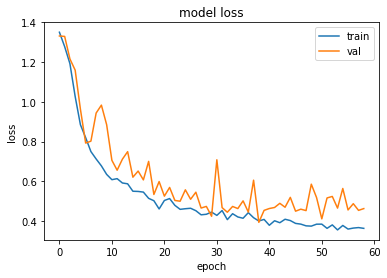

In [13]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

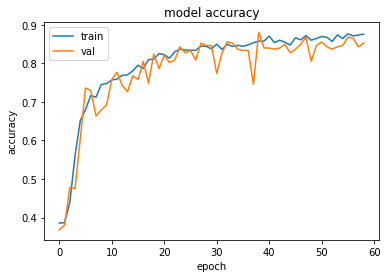

In [14]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("finalproject_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [16]:
# Load pretrained model (best saved one)
with open('finalproject_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('finalproject_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [17]:
scores = model.evaluate(test_ds)

2023-05-18 15:59:02.582032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 2000
2023-05-18 15:59:03.004268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 2000
2023-05-18 15:59:03.531075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 2000
2023-05-18 15:59:06.099376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8 of 2000


5/8 [=================>............] - ETA: 0s - loss: 0.4369 - accuracy: 0.8625

2023-05-18 15:59:06.328102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


8/8 [==============================] - 41s 34ms/step - loss: 0.4015 - accuracy: 0.8750


In [18]:
predict = []
y_test = np.array([])
for images, labels in test_ds:
    y_test = np.concatenate((y_test, labels.numpy()), axis=0).astype(int)
    predictions = model.predict(images)
    predict.extend(np.argmax(predictions, axis=1))
predict = np.asarray(predict)

In [19]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.875


<AxesSubplot:>

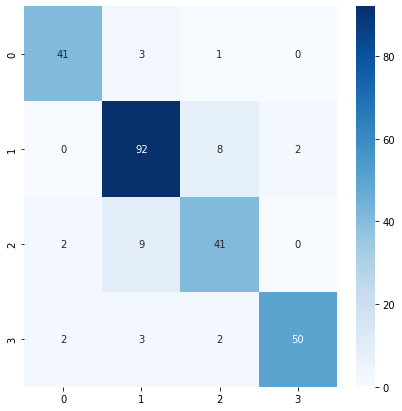

In [20]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

In [21]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.86      0.90      0.88       102
           2       0.79      0.79      0.79        52
           3       0.96      0.88      0.92        57

    accuracy                           0.88       256
   macro avg       0.88      0.87      0.87       256
weighted avg       0.88      0.88      0.88       256

